Demo #4: Forecasting with cutomized dependencies

Import libraries

In [26]:
import sys
import os
from pathlib import Path
# project_root = Path.cwd().parent
# sys.path.append(project_root)
project_root = Path("/Users/vuongdai/GitHub/canari")  
sys.path.append(str(project_root))  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from examples import DataProcess
from pytagi import Normalizer
import pytagi.metric as metric
import copy

Import components

In [ ]:
from src import (
    LocalTrend,
    LocalAcceleration,
    LstmNetwork,
    WhiteNoise,
    Model,
    ModelOptimizer,
    SKF,
    SKFOptimizer,
    plot_data,
    plot_prediction,
    plot_skf_states,
    plot_states,
)

Read data

In [ ]:
data_file = "/Users/vuongdai/GitHub/canari/data/benchmark_data/test_4_data.csv"
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, 1:]
df.index = time
df.index.name = "time"
df.columns = ["displacement_y", "water_level", "temp_min", "temp_max"]

,displacement_y,water_level,temp_min,temp_max
time,,,,
2010-11-07,6.595455,31.053636,-2.2,3.5
2010-11-14,6.523333,30.986667,-1.7,9.9
2010-11-21,6.430000,31.070000,-5.8,1.6
2010-11-28,6.360000,31.000000,-11.5,0.1
2010-12-05,6.210000,30.930000,-5.1,-1.1


Data preprocess

In [ ]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["week_of_year"],
    train_split=0.4,
    validation_split=0.07,
    output_col=output_col,
)
train_data, validation_data, test_data, normalized_data = data_processor.get_splits()

Define components

In [ ]:
local_trend = LocalTrend()
local_acceleration = LocalAcceleration()
pattern = LstmNetwork(
        look_back_len=14,
        num_features=10, # number of data's columns + time covariates
        num_layer=1,
        num_hidden_unit=50,
        device="cpu",
        manual_seed=1,
    )
residual = WhiteNoise(std_error=0.04168)

Define normal and abnormal models

In [ ]:
# Normal model
model = Model(
    local_trend,
    pattern,
    residual,
)

#  Abnormal model
ab_model = Model(
    local_acceleration,
    pattern,
    residual,
)

Define SKF model

In [ ]:
# Switching Kalman filter
skf = SKF(
    norm_model=model,
    abnorm_model=ab_model,
    std_transition_error=1e-4,
    norm_to_abnorm_prob=1e-4,
    abnorm_to_norm_prob=1e-1,
    norm_model_prior_prob=0.99,
)

Train model -- Objective: train LSTM neural network -- model.lstm_train()

In [33]:
model.auto_initialize_baseline_states(train_data["y"][0 : 52 * 3])
max_num_epoch = 50
states_optim = None
mu_validation_preds_optim = None
std_validation_preds_optim = None

for epoch in range(max_num_epoch):
    mu_validation_preds, std_validation_preds, states = model.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )

    mu_validation_preds_unnorm = Normalizer.unstandardize(
        mu_validation_preds,
        data_processor.norm_const_mean[data_processor.output_col],
        data_processor.norm_const_std[data_processor.output_col],
    )

    std_validation_preds_unnorm = Normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.norm_const_std[data_processor.output_col],
    )

    validation_obs = data_processor.get_data("validation").flatten()
    validation_log_lik = metric.log_likelihood(
        prediction=mu_validation_preds_unnorm,
        observation=validation_obs,
        std=std_validation_preds_unnorm,
    )

    model.early_stopping(evaluate_metric=-validation_log_lik, mode="min")

    if epoch == model.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds.copy()
        std_validation_preds_optim = std_validation_preds.copy()
        states_optim = copy.copy(states)
    if model.stop_training:
        break

Learning's curve

Optinal epoch       : 19
Validation MSE      :-0.8659


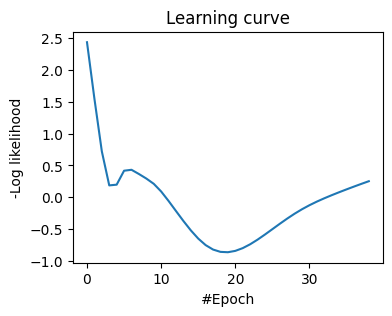

In [34]:
fig,ax = plt.subplots(figsize=(4,3))
plt.plot(model.early_stop_metric_history)
ax.set_ylabel("-Log likelihood")
ax.set_xlabel("#Epoch")
plt.title("Learning curve")
print(f"Optinal epoch       : {model.optimal_epoch}")
print(f"Validation MSE      :{model.early_stop_metric: 0.4f}")

Plot predictions

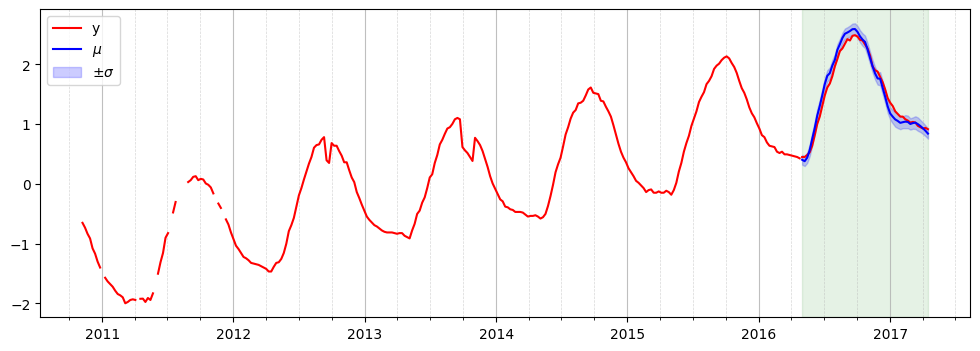

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(
    data_processor=data_processor,
    normalization=True,
    plot_test_data=False,
    plot_column=output_col,
    validation_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mu_validation_pred=mu_validation_preds_optim,
    std_validation_pred=std_validation_preds_optim,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plt.legend()
plt.show()

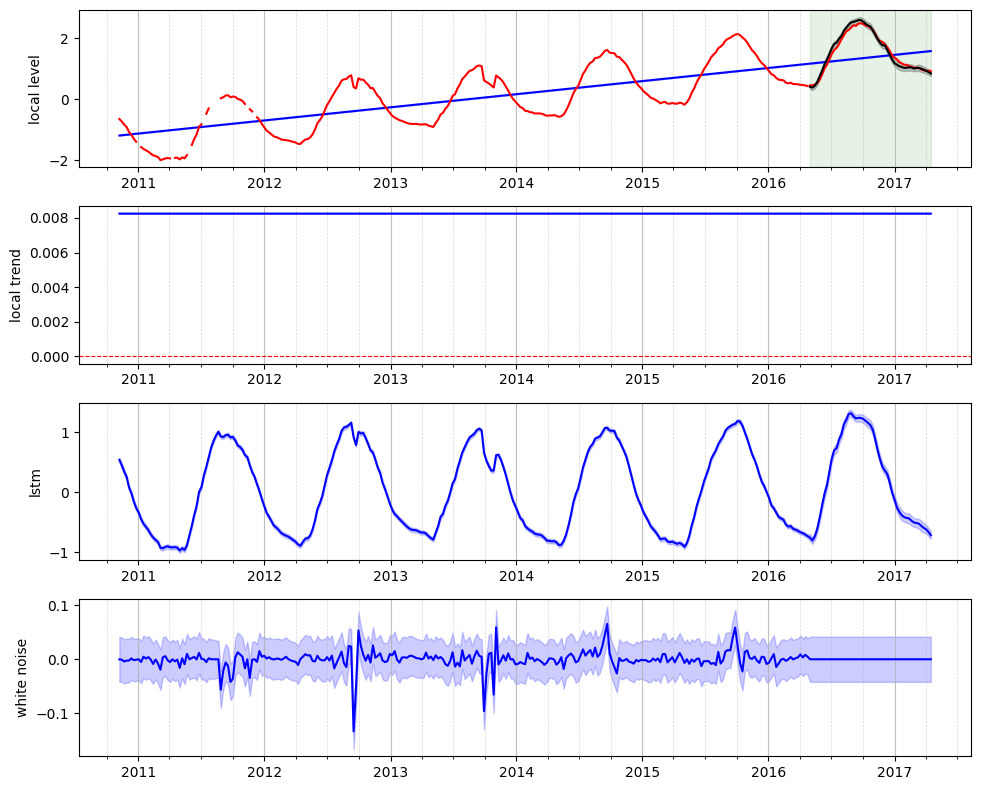

In [36]:
fig, ax =plot_states(data_processor=data_processor,
                     states=states)
plot_data(data_processor=data_processor,
        normalization=True,
        plot_test_data=False,
        sub_plot=ax[0])
plot_prediction(data_processor=data_processor,
                mu_validation_pred=mu_validation_preds_optim,
                std_validation_pred = std_validation_preds_optim,
                sub_plot=ax[0],
                color="k",
                )
plt.show()